In [1]:
import gc
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr

%load_ext autoreload
%autoreload 2

from delay_discounting_mvpa.config_loader import load_config
from delay_discounting_mvpa.fmri_io import load_bold_estimates
from delay_discounting_mvpa.io_utils import get_subids, load_tsv_data, resolve_file

In [2]:
config_file = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/configs/config.yaml'
cfg = load_config(config_file)

In [3]:
mask = Path(f'{cfg.masks_dir}/Precentral_L_mask.nii.gz')
mask.exists()

subids_txt_file = Path('../good_subjects/good_subids.txt')
with open(subids_txt_file, 'r') as f:
    subids = [line.strip() for line in f if line.strip()]


lsa_output_root = cfg.output_root / 'lsa_estimates'

In [39]:
subid = subids[40]
print(subid)
lsa_path = lsa_output_root / f'sub-{subid}_beta_series.nii.gz'
lsa_path.exists()

s590


True

In [40]:
roi_data, masker = load_bold_estimates(
    cfg, lsa_path, mask_type='roi', roi_mask_name='Precentral_L_mask.nii.gz'
)

In [41]:
brain_data, masker_brain = load_bold_estimates(cfg, lsa_path, mask_type='brain')


In [42]:
behav_data_file = resolve_file(cfg, subid, 'behav')
behav_data = pd.read_csv(behav_data_file, sep='\t')

In [43]:
# metric='correlation' for correlation distance
# metric='euclidean' for euclidean
beta_dist_matrix = squareform(pdist(roi_data, metric='euclidean'))

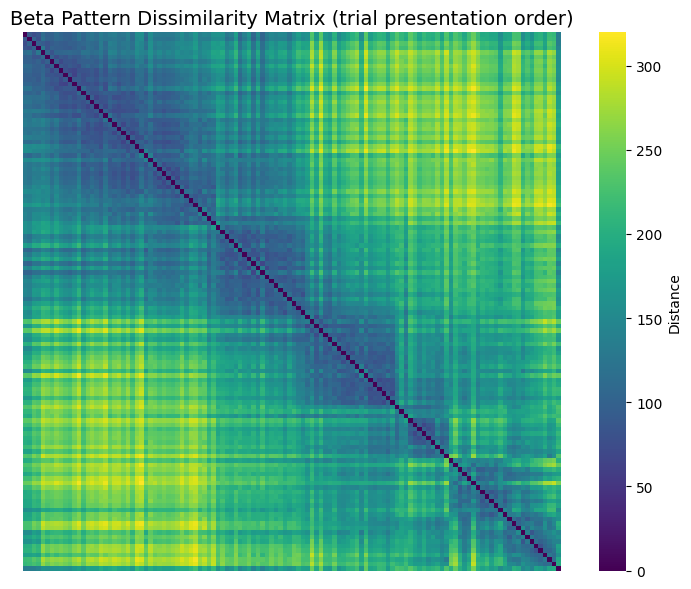

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    beta_dist_matrix,
    cmap='viridis',  # good perceptual colormap
    square=True,  # make cells square
    cbar_kws={'label': 'Distance'},  # label colorbar
    xticklabels=False,  # hide labels if many trials
    yticklabels=False,
)
plt.title('Beta Pattern Dissimilarity Matrix (trial presentation order)', fontsize=14)
plt.tight_layout()
plt.show()

## Verify that the pattern persists if I randomly select voxels

(120, 2600)
[ 84891   5773 101206 128729 138697]
137.14503962467046


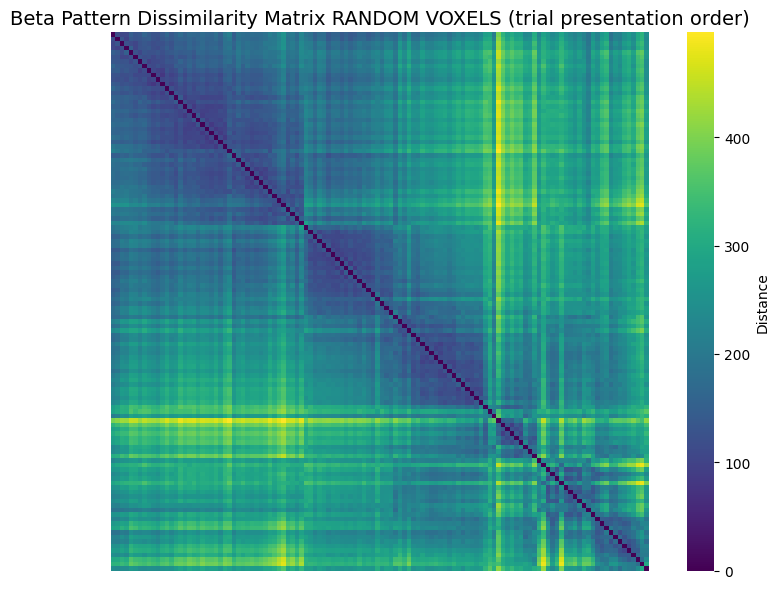

In [46]:
n_voxels = 2600
cols = np.random.choice(brain_data.shape[1], size=n_voxels, replace=False)
# Subset the matrix
sampled_data = brain_data[:, cols]

print(sampled_data.shape)
print(cols[:5])
beta_dist_matrix_random = squareform(pdist(sampled_data, metric='euclidean'))
print(beta_dist_matrix_random[1, 4])

plt.figure(figsize=(8, 6))
sns.heatmap(
    beta_dist_matrix_random,
    cmap='viridis',  # good perceptual colormap
    square=True,  # make cells square
    cbar_kws={'label': 'Distance'},  # label colorbar
    xticklabels=False,  # hide labels if many trials
    yticklabels=False,
)
plt.title(
    'Beta Pattern Dissimilarity Matrix RANDOM VOXELS (trial presentation order)',
    fontsize=14,
)
plt.tight_layout()
plt.show()

## Test the whether the beta series distance is realted to the onset distances (they are strongly related)
This is to verify my suspicions that the structure we're seeing is driven by the timings of the events.

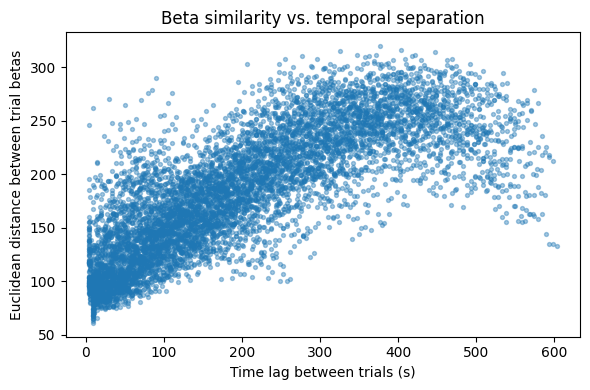

Pearson r = 0.777 (p=0)
Spearman ρ = 0.816 (p=0)


In [47]:
# --- Compute the time distance matrix ---
# behav_data should have an 'onset' column with trial onset times (in seconds)
onsets = behav_data['onset'].values
time_dist_matrix = squareform(pdist(onsets[:, None], metric='euclidean'))

# --- Extract the upper triangle (excluding diagonal) ---
triu_idx = np.triu_indices_from(beta_dist_matrix, k=1)
beta_dists = beta_dist_matrix[triu_idx]
time_dists = time_dist_matrix[triu_idx]

# --- Scatterplot: time lag vs. beta distance ---
plt.figure(figsize=(6, 4))
plt.scatter(time_dists, beta_dists, s=8, alpha=0.4)
plt.xlabel('Time lag between trials (s)')
plt.ylabel('Euclidean distance between trial betas')
plt.title('Beta similarity vs. temporal separation')
plt.tight_layout()
plt.show()

# --- (Optional) Compute correlation between time lag and beta distance ---

r_pearson, p_pearson = pearsonr(time_dists, beta_dists)
r_spearman, p_spearman = spearmanr(time_dists, beta_dists)
print(f'Pearson r = {r_pearson:.3f} (p={p_pearson:.3g})')
print(f'Spearman ρ = {r_spearman:.3f} (p={p_spearman:.3g})')

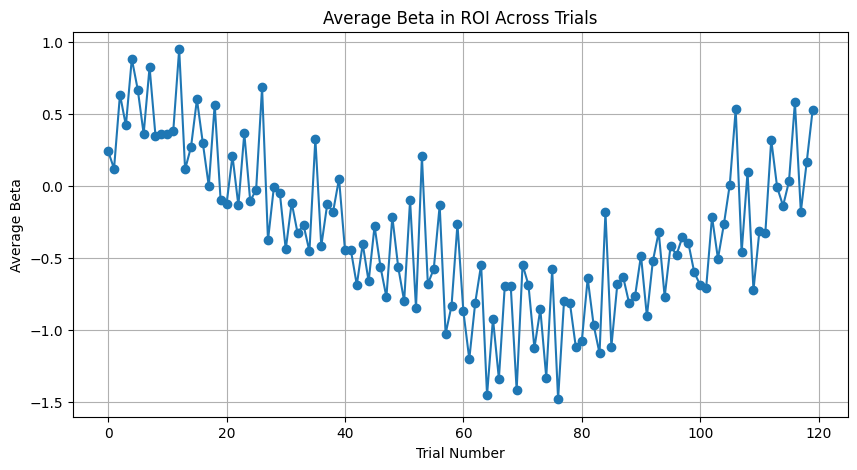

In [48]:
# curious about the average beta series plot
mean_beta = roi_data.mean(axis=1)  # shape: (120,)

# 2. Plot as a function of trial/time
plt.figure(figsize=(10, 5))
plt.plot(mean_beta, marker='o')
plt.xlabel('Trial Number')
plt.ylabel('Average Beta')
plt.title('Average Beta in ROI Across Trials')
plt.grid(True)
plt.show()

In [12]:
spearman_cor = []
for subid in subids:
    print(subid)
    # --- Load ROI beta series ---
    lsa_path = lsa_output_root / f'sub-{subid}_beta_series.nii.gz'
    roi_data, masker = load_bold_estimates(
        cfg, lsa_path, mask_type='roi', roi_mask_name='Precentral_L_mask.nii.gz'
    )

    # --- Load behavioral data ---
    behav_data_file = resolve_file(cfg, subid, 'behav')
    behav_data = pd.read_csv(behav_data_file, sep='\t')

    # --- Compute beta dissimilarity ---
    beta_dist_matrix = squareform(pdist(roi_data, metric='euclidean'))

    # --- Compute the time distance matrix ---
    # behav_data should have an 'onset' column with trial onset times (in seconds)
    onsets = behav_data['onset'].values
    time_dist_matrix = squareform(pdist(onsets[:, None], metric='euclidean'))

    # --- Extract the upper triangle (excluding diagonal) ---
    triu_idx = np.triu_indices_from(beta_dist_matrix, k=1)
    beta_dists = beta_dist_matrix[triu_idx]
    time_dists = time_dist_matrix[triu_idx]
    r_spearman, p_spearman = spearmanr(time_dists, beta_dists)
    spearman_cor.append(r_spearman)

s061
s130
s172
s192
s234
s251
s358
s373
s471
s483
s497
s512
s518
s524
s525
s526
s541
s546
s548
s549
s553
s554
s555
s556
s557
s561
s567
s568
s570
s573
s574
s577
s579
s581
s582
s583
s584
s585
s587
s589
s590
s591
s592
s593
s594
s595
s596
s597
s601
s602
s604
s606
s607
s609
s610
s611
s612
s613
s614
s615
s616
s617
s618
s621
s622
s623
s624
s626
s627
s628
s629
s631
s633
s634
s635
s636
s637
s638
s641
s642
s643
s644
s645
s648
s650


0.5376761462768938


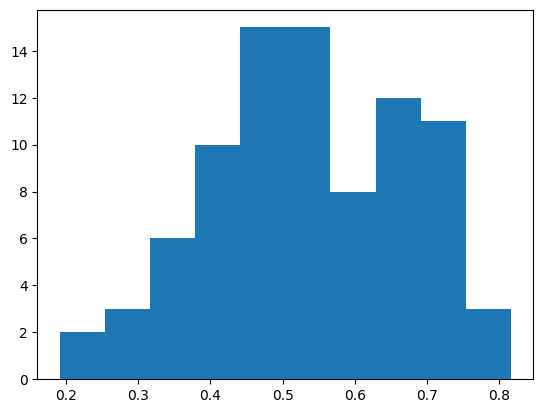

In [13]:
print(np.mean(spearman_cor))

plt.hist(spearman_cor)
plt.show()